In [3]:
%load_ext autoreload
%autoreload 2

if __name__ == '__main__':
    import sys
    import os
    from pathlib import Path
    curr_file_path = Path(os.path.abspath(''))
    sys.path.append(str(curr_file_path.parent))
    sys.path.append(os.path.join(str(curr_file_path.parent.parent.parent), 'fixed-point-finder'))

import os
from pathlib import Path
import json
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib import colormaps
from mpl_toolkits.mplot3d import Axes3D
from math import sqrt
from aux_funcs import format_plot, add_pc_axes, format_pc_plot
import torch
import torch.nn as nn
import gymnasium as gym
import neurogym as ngym
from FixedPointFinderTorch import FixedPointFinderTorch as FixedPointFinder
from math import sqrt


device = 'cuda' if torch.cuda.is_available() else 'cpu'

envid = 'DelayMatchSample-v0'

In [4]:
def get_modelpath(envid):
    # Make a local file directories
    path = Path('.') / 'files'
    os.makedirs(path, exist_ok=True)
    path = path / envid
    os.makedirs(path, exist_ok=True)
    return path

In [5]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, unit_noise_std=0.1):
        super(Net, self).__init__()
        self.rnn = nn.RNNCell(input_size, hidden_size, nonlinearity='relu')
        self.linear = nn.Linear(hidden_size, output_size)
        self.hidden_size = hidden_size
        self.unit_noise_std =  unit_noise_std

    def forward(self, x):
        batch_size = x.shape[1]
        seq_len = x.shape[0]
        
        h = torch.zeros(batch_size, self.hidden_size)
        all_h = []
        x_out = []

        for t in range(seq_len):
            h = self.rnn(x[t], h)
        
            # Add noise to hidden state after each step
            noise = torch.normal(torch.zeros(batch_size, self.hidden_size)) * self.unit_noise_std / sqrt(self.hidden_size)  # adjust std as needed
            h = h + noise

            all_h.append(h.unsqueeze(0))
            x_out.append(self.linear(h).unsqueeze(0))
        
        # Final output shape: (seq_len, batch_size, hidden_size)
        all_h = torch.cat(all_h, dim=0)
        x_out = torch.cat(x_out, dim=0)
        
        return x_out, all_h

In [395]:
def ortho_mat(size):
    # Andrew Saxe init
    q, r = torch.linalg.qr(torch.randn(*size))
    d = torch.diag(r)
    q *= d.sign()
    return q

C:\Users\david.bell\AppData\Local\Temp\ipykernel_12648\253694386.py:68: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  w_hh[i+chain_width:i+2*chain_width, i:i+chain_width] = np.sqrt(2) * ortho_mat((chain_width, chain_width))


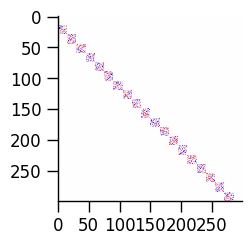

Training task  DelayMatchSample-v0
50 loss: 0.36046
100 loss: 0.17198
150 loss: 0.14897
200 loss: 0.16386
250 loss: 0.11934
300 loss: 0.10138
350 loss: 0.05571
400 loss: 0.02348
450 loss: 0.01455
500 loss: 0.01169
550 loss: 0.00643
600 loss: 0.00490
650 loss: 0.00392
700 loss: 0.00317
750 loss: 0.00277
800 loss: 0.00214
850 loss: 0.00214
900 loss: 0.00196
950 loss: 0.00140


KeyboardInterrupt: 

In [413]:
"""Supervised training networks.

Save network in a path determined by environment ID.

Args:
    envid: str, environment ID.
"""
modelpath = get_modelpath(envid)
config = {
    'dt': 100,
    'hidden_size':  10 * 30, # 3 * seq_len
    'lr': 1e-3,
    'batch_size': 50,
    'seq_len': 100,
    'envid': envid,
    'delay': tuple([x for x in range(100, 1100, 100)]),
    'fixation': tuple([x for x in range(100, 600, 100)]),
    'decision': tuple([x for x in range(100, 600, 100)]),
    'dim_ring': 20,
}


env_kwargs = {
    'dt': config['dt'],
    'timing': {
        'delay': config['delay'],
        'fixation': config['fixation'],
        'decision': config['decision'],
    },
    'dim_ring': config['dim_ring'],
}
config['env_kwargs'] = env_kwargs

# Save config
with open(modelpath / 'config.json', 'w') as f:
    json.dump(config, f)

# Make supervised dataset
dataset = ngym.Dataset(
    envid,
    env_kwargs=env_kwargs,
    batch_size=config['batch_size'],
    seq_len=config['seq_len'],
)
env = dataset.env
act_size = env.action_space.n
# Train network
net = Net(input_size=env.observation_space.shape[0],
          hidden_size=config['hidden_size'],
          output_size=act_size)

hidden_size = config['hidden_size']
input_size = env.observation_space.shape[0]
chain_width = 15

# Andrew Saxe init
# w_hh = ortho_mat((hidden_size, hidden_size))
# w_ih = np.random.normal(size=(hidden_size, input_size), scale=2/np.sqrt(input_size))

# net.rnn.weight_hh.data = sqrt(2) * w_hh
# net.rnn.bias_hh.data = torch.zeros((hidden_size)).float()
# net.rnn.weight_ih.data = torch.from_numpy(w_ih).float()
# net.rnn.bias_ih.data = torch.zeros((hidden_size)).float()

# # Seq init
w_hh = np.zeros((hidden_size, hidden_size))
for i in range(0, hidden_size - chain_width, chain_width):
    w_hh[i+chain_width:i+2*chain_width, i:i+chain_width] = np.sqrt(2) * ortho_mat((chain_width, chain_width))

w_ih = np.zeros((hidden_size, input_size))
w_ih[:chain_width, :] = np.random.normal(size=(chain_width, input_size), scale=2/np.sqrt(input_size))

    
net.rnn.weight_hh.data = torch.from_numpy(w_hh).float()
net.rnn.bias_hh.data = torch.zeros((hidden_size)).float()
net.rnn.weight_ih.data = torch.from_numpy(w_ih).float()
net.rnn.bias_ih.data = torch.zeros((hidden_size)).float()


scale = 1.2
fig, axs = plt.subplots(1, 1, figsize=(2 * scale, 2 * scale))
w_hh = net.rnn.weight_hh.detach().cpu().numpy()
m = np.abs(w_hh).max()
axs.matshow(net.rnn.weight_hh.detach().cpu().numpy(), cmap='bwr', vmin=-m, vmax=m)
format_plot(axs)
plt.show()

net = net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=config['lr'])

print('Training task ', envid)

running_loss = 0.0
training_iters = 5000
for i in range(training_iters):
    inputs, labels = dataset()
    inputs = torch.from_numpy(inputs).type(torch.float).to(device)
    labels = torch.from_numpy(labels.flatten()).type(torch.long).to(device)

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs, _ = net(inputs)

    # print(outputs.view(-1, act_size).shape)

    loss = criterion(outputs.view(-1, act_size), labels)
    loss.backward()

    # # zero out non-sequential part of gradient
    # for i in range(0, hidden_size - chain_width, chain_width):
    #     net.rnn.weight_hh.grad[:i+chain_width, i:i+chain_width] = 0
    #     net.rnn.weight_hh.grad[i+2*chain_width:, i:i+chain_width] = 0

    optimizer.step()

    # print statistics
    running_loss += loss.item()
    save_freq = 50
    if training_iters == 1 or i % save_freq == (save_freq - 1):
        print('{:d} loss: {:0.5f}'.format(i + 1, running_loss / save_freq))
        running_loss = 0.0
        torch.save(net.state_dict(), modelpath / 'net.pth')

print('Finished Training')

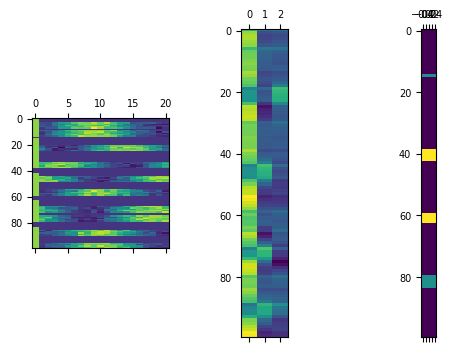

In [398]:
batch_idx = 5

scale = 5
fig, axs = plt.subplots(1, 3, figsize=(1.2 * scale, 0.8 * scale))
axs[0].matshow(inputs.cpu()[:, batch_idx, :], aspect=0.2)
axs[1].matshow(outputs.detach().cpu()[:, batch_idx, :], aspect=0.2)
axs[2].matshow(labels.detach().cpu().view(100, 50)[:, batch_idx][:, None], aspect=0.2)
plt.show()

In [399]:
def infer_test_timing(env):
    """Infer timing of environment for testing."""
    timing = {}
    for period in env.timing.keys():
        period_times = [env.sample_time(period) for _ in range(100)]
        timing[period] = np.median(period_times)
    return timing

{'dt': 100, 'hidden_size': 300, 'lr': 0.001, 'batch_size': 50, 'seq_len': 100, 'envid': 'DelayMatchSample-v0', 'delay': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], 'fixation': [100, 200, 300, 400, 500], 'decision': [100, 200, 300, 400, 500], 'dim_ring': 20, 'env_kwargs': {'dt': 100, 'timing': {'delay': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], 'fixation': [100, 200, 300, 400, 500], 'decision': [100, 200, 300, 400, 500]}, 'dim_ring': 20}}


C:\Users\david.bell\AppData\Local\anaconda3\envs\neurogym\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.timing to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.timing` for environment variables or `env.get_wrapper_attr('timing')` that will search the reminding wrappers.
  logger.warn(
C:\Users\david.bell\AppData\Local\anaconda3\envs\neurogym\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.sample_time to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.sample_time` for environment variables or `env.get_wrapper_attr('sample_time')` that will search the reminding wrappers.
  logger.warn(


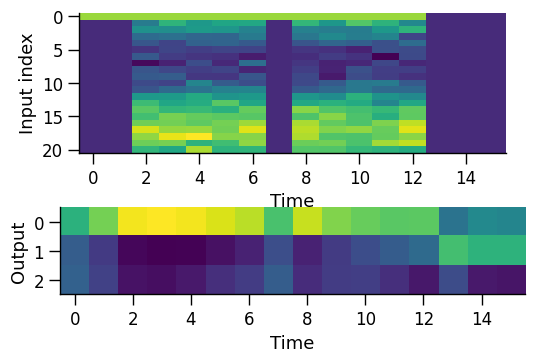

C:\Users\david.bell\AppData\Local\anaconda3\envs\neurogym\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.trial to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.trial` for environment variables or `env.get_wrapper_attr('trial')` that will search the reminding wrappers.
  logger.warn(
C:\Users\david.bell\AppData\Local\Temp\ipykernel_12648\720752529.py:73: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  activity.append(np.array(hidden.cpu())[:, 0, :])  # shape (T, hidden_dim)


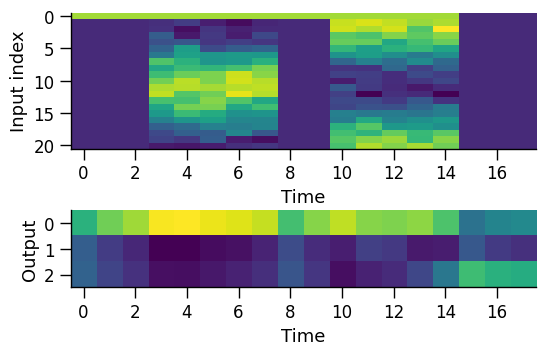

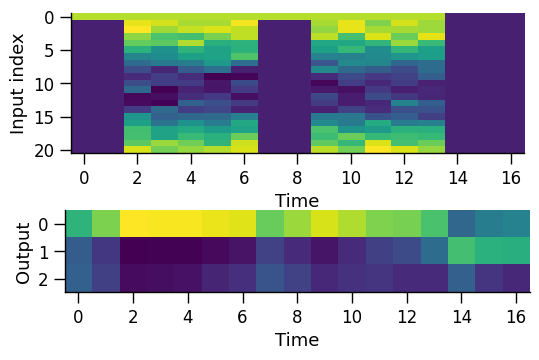

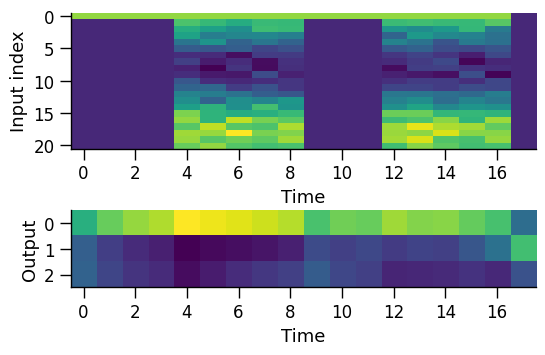

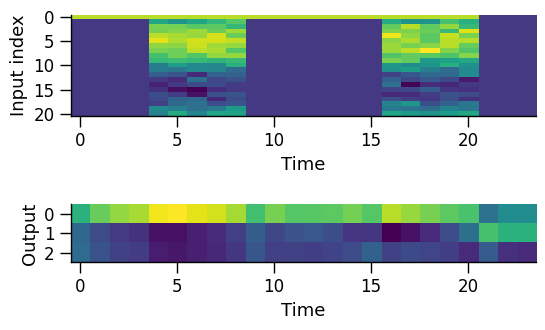

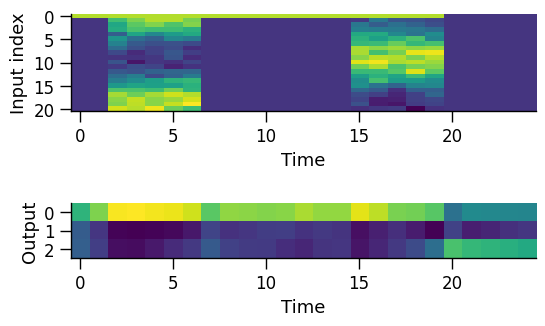

(16, 300)
(18, 300)
(17, 300)
(18, 300)
Average performance 1.0


In [400]:
"""Run trained networks for analysis.

Args:
    envid: str, Environment ID

Returns:
    activity: a list of activity matrices, each matrix has shape (
    N_time, N_neuron)
    info: pandas dataframe, each row is information of a trial
    config: dict of network, training configurations
"""
# Load model config
modelpath = get_modelpath(envid)
with open(modelpath / 'config.json') as f:
    config = json.load(f)
    print(config)

env_kwargs = config['env_kwargs']

# Create environment
env = gym.make(envid, **env_kwargs)
env.timing = infer_test_timing(env)
_ = env.reset()  # gym >=0.26: reset() returns (obs, info)

# Load model
with torch.no_grad():
    net = Net(
        input_size=env.observation_space.shape[0],
        hidden_size=config['hidden_size'],
        output_size=env.action_space.n
    ).to(device)

    net.load_state_dict(torch.load(modelpath / 'net.pth', map_location=device))

    num_trial = 100
    activity = []
    info_rows = []  # collect rows as dicts
    obs = []

    for _ in range(num_trial):
        env.new_trial()
        ob, gt = env.ob, env.gt

        inputs = torch.from_numpy(ob[:, np.newaxis, :]).float()
        action_pred, hidden = net(inputs.to(device))

        # Evaluate performance
        action_pred = action_pred.detach().cpu().numpy()
        choice = np.argmax(action_pred[-1, 0, :])
        correct = choice == gt[-1]

        if _ < 6:
            scale = 5
            fig, axs = plt.subplots(2, 1, figsize=(1.2 * scale, 0.8 * scale))
            axs[0].matshow(ob.T, aspect=0.25)
            axs[0].set_xlabel('Time')
            axs[0].set_ylabel('Input index')

            axs[1].matshow(action_pred.T.squeeze())
            axs[1].set_xlabel('Time')
            axs[1].set_ylabel('Output')

            format_plot(axs)
            plt.show()
        

        # Log trial info
        trial_info = env.trial.copy()  # make a copy so we don’t modify env
        trial_info.update({'correct': correct, 'choice': choice})
        info_rows.append(trial_info)

        # Log hidden activity
        activity.append(np.array(hidden.cpu())[:, 0, :])  # shape (T, hidden_dim)
        obs.append(ob)

    # Finalize outputs
    info = pd.DataFrame(info_rows)
    print(activity[0].shape)
    print(activity[1].shape)
    print(activity[2].shape)
    print(activity[3].shape)
    # activity = np.array(activity)  # shape (num_trial, T, hidden_dim)

    print('Average performance', np.mean(info['correct']))

Text(0, 0.5, 'Unit')

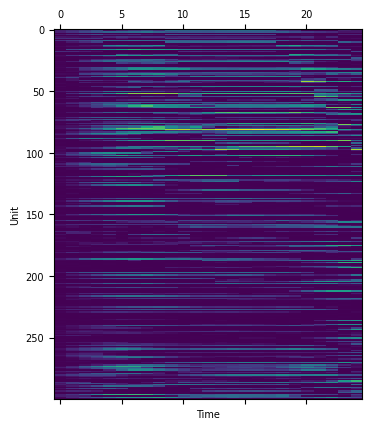

In [402]:
scale = 6
fig, axs = plt.subplots(1, 1, figsize=(1.2 * scale, 0.8 * scale))
axs.matshow(activity[6].T, aspect=0.1)
axs.set_xlabel('Time')
axs.set_ylabel('Unit')

In [403]:
def get_conditions(info):
    """Get a list of task conditions to plot."""
    conditions = info.columns
    # This condition's unique value should be less than 5
    new_conditions = list()
    for c in conditions:
        try:
            n_cond = len(pd.unique(info[c]))
            if 1 < n_cond < 5:
                new_conditions.append(c)
        except TypeError:
            pass
        
    return new_conditions

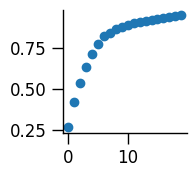

In [404]:
activity_copy = np.concatenate(activity, axis=0)
activity_reshape = np.reshape(activity_copy, (-1, activity_copy.shape[-1]))
pca = PCA()
pc_activities = pca.fit(activity_reshape)
# axs[0, 0].set_title('Activity colored by rewards seen in patch')
# fig.tight_layout()
# format_pc_plot(axs)
scale = 2
fig, axs = plt.subplots(1, 1, figsize=(0.8 * scale, 0.8 * scale))
axs.scatter(np.arange(20), np.cumsum(pca.explained_variance_ratio_[:20]))
format_plot(axs)

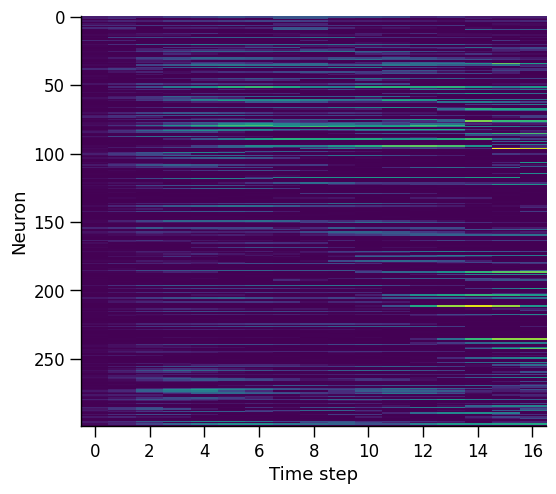

In [406]:
scale = 3
fig, axs = plt.subplots(1, 1, figsize=(2 * scale, 2 * scale))

axs.matshow(activity[2].T, aspect=0.05)
axs.set_xlabel('Time step')
axs.set_ylabel('Neuron')
format_plot(axs)

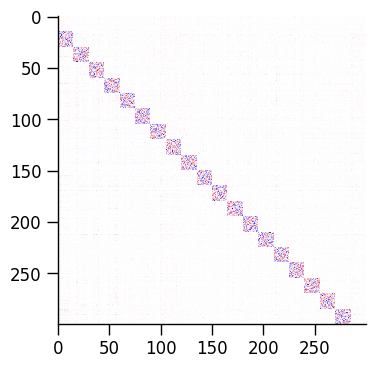

In [407]:
scale = 2
fig, axs = plt.subplots(1, 1, figsize=(2 * scale, 2 * scale))
w_hh = net.rnn.weight_hh.detach().cpu().numpy()
m = np.abs(w_hh).max()
axs.matshow(net.rnn.weight_hh.detach().cpu().numpy(), cmap='bwr', vmin=-m, vmax=m)
format_plot(axs)

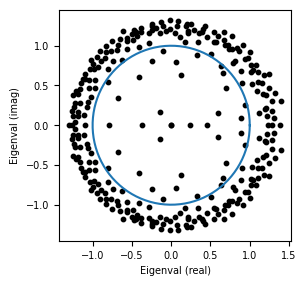

In [408]:
scale = 1.5
fig, axs = plt.subplots(1, 1, figsize=(2 * scale, 2 * scale), sharex=True)
res = np.linalg.eig(w_hh)
eigen_vals = res.eigenvalues
axs.scatter(eigen_vals.real, eigen_vals.imag, s=10, c='black')
x = np.linspace(0, 2 * np.pi, 100)
axs.plot(np.cos(x), np.sin(x))
axs.set_xlabel('Eigenval (real)')
axs.set_ylabel('Eigenval (imag)')
plt.show()

0
1


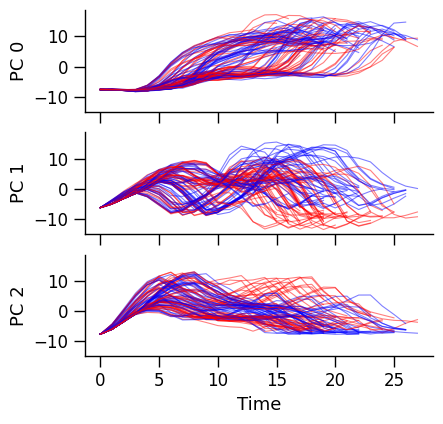

In [409]:
scale = 1.5
fig, ax = plt.subplots(3, 1, figsize=(3 * scale, 3 * scale), sharex=False, sharey=True)

for k in np.arange(0, 3, 3):  # Plot trajectories for k and k+1 components
    for i in range(info.shape[0]):
        color = 'red' if int(info.iloc[i]['ground_truth']) == 1 else 'blue'

        # Extract full trajectory over time for this sample and component pair
        pc_activities = pca.transform(activity[i])
        T = pc_activities.shape[1]
        t = np.arange(len(activity[i]))

        ax[0].plot(t, pc_activities[:, k], color=color, alpha=0.5, linewidth=0.8)
        ax[1].plot(t, pc_activities[:, k+1], color=color, alpha=0.5, linewidth=0.8)
        ax[2].plot(t, pc_activities[:, k+2], color=color, alpha=0.5, linewidth=0.8)

        format_plot(ax)

for i in range(k+2):
    print(i)
    ax[i].set_xticklabels([])

ax[0].set_ylabel(f'PC {k}')
ax[1].set_ylabel(f'PC {k+1}')
ax[2].set_ylabel(f'PC {k+2}')
ax[-1].set_xlabel('Time')
plt.show()
None

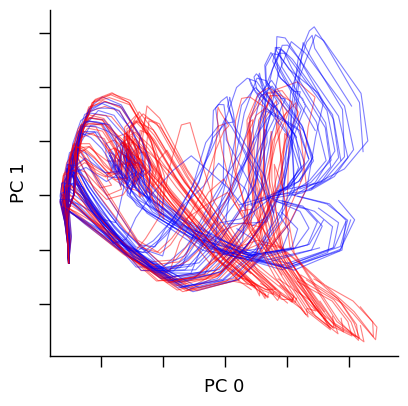

In [410]:
scale = 1.5
fig, ax = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale), sharex=False, sharey=True)

all_pc_activities = []

for k in np.arange(0, 2, 2):  # Plot trajectories for k and k+1 components
    for i in range(info.shape[0]):
        color = 'red' if int(info.iloc[i]['ground_truth']) == 1 else 'blue'

        # Extract full trajectory over time for this sample and component pair
        pc_activities = pca.transform(activity[i])
        all_pc_activities.append(pc_activities)
        T = pc_activities.shape[0]
        t = np.arange(len(activity[i]))

        ax.plot(pc_activities[:, k], pc_activities[:, k+1], color=color, alpha=0.5, linewidth=0.8)

        format_plot(ax)

all_pc_activities = np.concatenate(all_pc_activities, axis=0)
maxes = all_pc_activities.max(axis=0)
mins = all_pc_activities.min(axis=0)
ax.set_xlim(1.1 * mins[0], 1.1 * maxes[0])
ax.set_ylim(1.1 * mins[1], 1.1 * maxes[1])

ax.set_xticklabels([])
ax.set_yticklabels([])

ax.set_xlabel(f'PC {k}')
ax.set_ylabel(f'PC {k+1}')

plt.show()
None

In [411]:
def detect_timing_and_features(ob):
    fixation_cue = ob[:, 0]
    stim = ob[:, 1:]
    stim_mean = stim.mean(axis=1)

    stim_onsets = np.arange(ob.shape[0])[(stim_mean > 0) & (np.roll(stim_mean, 1) == 0)]
    stim_offsets = np.arange(ob.shape[0])[(stim_mean == 0) & (np.roll(stim_mean, 1) > 0)]

    stim_1 = stim[stim_onsets[0]:stim_offsets[0], :].mean(axis=0)
    stim_2 = stim[stim_onsets[1]:stim_offsets[1], :].mean(axis=0)

    stim_1_loc = np.argmax(stim_1)
    stim_2_loc = np.argmax(stim_2)
    
    return stim_onsets, stim_offsets, stim_1_loc, stim_2_loc

In [259]:
def value_to_hex_color(value, vmin=0, vmax=1, cmap_name='viridis'):
    """
    Maps a value in the range [vmin, vmax] to a hex color using the given matplotlib colormap.

    Parameters:
        value (float): The input value to map.
        vmin (float): The minimum value of the range.
        vmax (float): The maximum value of the range.
        cmap_name (str): Name of the matplotlib colormap to use.

    Returns:
        str: Hex color string (e.g., "#1f77b4").
    """
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax, clip=True)
    
    # Use new recommended colormap API (Matplotlib 3.7+)
    cmap = colormaps.get_cmap(cmap_name)

    rgba = cmap(norm(value))
    return mcolors.to_hex(rgba)

In [260]:
def plot_dynamics(start, end, color_var, cmap='plasma', max_color_var=1, start_mod=0, end_mod=0):
    scale = 1.5
    fig, ax = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale), sharex=False, sharey=True)
    
    all_pc_activities = []
    
    for k in np.arange(0, 2, 2):  # Plot trajectories for k and k+1 components
        for i in range(info.shape[0]):
    
            # Extract full trajectory over time for this sample and component pair
            pc_activities = pca.transform(activity[i])
            all_pc_activities.append(pc_activities)
            T = pc_activities.shape[0]
            t = np.arange(len(activity[i]))
    
            ob = obs[i]
            stim_onsets, stim_offsets, stim_1_loc, stim_2_loc = detect_timing_and_features(ob)
    
            task_properties = {
                'stim_1_loc': stim_1_loc,
                'stim_2_loc': stim_2_loc,
                'gt': int(info.iloc[i]['ground_truth']) == 1,
                'stim_onset_1': stim_onsets[0],
                'stim_onset_2': stim_onsets[1],
                'stim_offset_1': stim_offsets[0],
                'stim_offset_2': stim_offsets[1],
            }

            start_ = task_properties[start] if type(start) == str else start
            end_ = task_properties[end] if type(end) == str else end

            if end_ is None:
                period = slice(start_ + start_mod, end_)
            else:
                period = slice(start_ + start_mod, end_ + end_mod)
            
            ax.plot(
                pc_activities[period, k],
                pc_activities[period, k+1],
                color=value_to_hex_color(task_properties[color_var], vmax=max_color_var, cmap_name=cmap),
                alpha=0.5,
                linewidth=0.8
            )
    
            format_plot(ax)
    
    all_pc_activities = np.concatenate(all_pc_activities, axis=0)
    maxes = all_pc_activities.max(axis=0)
    mins = all_pc_activities.min(axis=0)
    ax.set_xlim(1.1 * mins[0], 1.1 * maxes[0])
    ax.set_ylim(1.1 * mins[1], 1.1 * maxes[1])
    
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    ax.set_xlabel(f'PC {k}')
    ax.set_ylabel(f'PC {k+1}')
    
    plt.show()

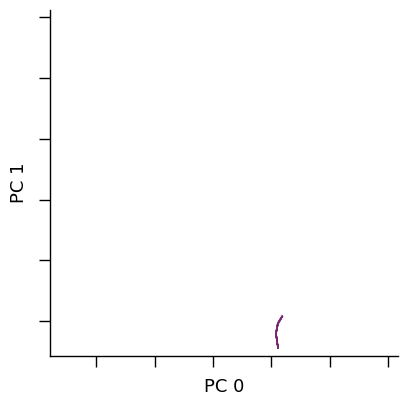

In [261]:
plot_dynamics(
    start=0,
    end='stim_onset_1',
    color_var='gt',
    cmap='Spectral',
    max_color_var=1,
    start_mod=0,
    end_mod=0,
)

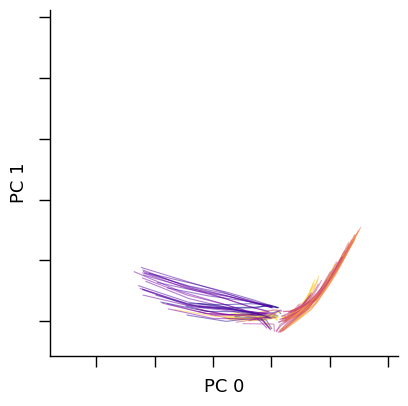

In [262]:
plot_dynamics(
    start='stim_onset_1',
    end='stim_offset_1',
    color_var='stim_1_loc',
    cmap='plasma',
    max_color_var=config['dim_ring'],
    start_mod=0,
    end_mod=0,
)

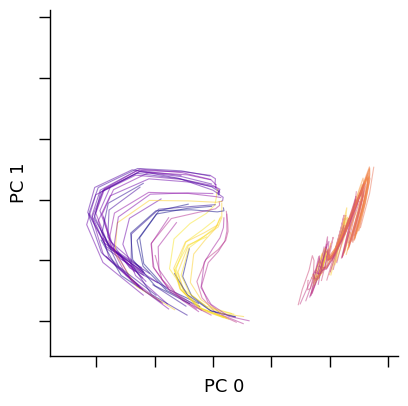

In [263]:
plot_dynamics(
    start='stim_offset_1',
    end='stim_onset_2',
    color_var='stim_1_loc',
    cmap='plasma',
    max_color_var=config['dim_ring'],
    start_mod=-1,
    end_mod=0,
)

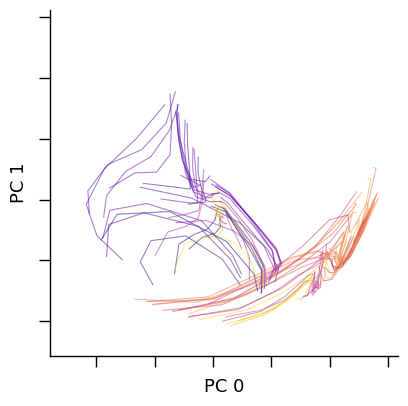

In [264]:
plot_dynamics(
    start='stim_onset_2',
    end='stim_offset_2',
    color_var='stim_1_loc',
    cmap='plasma',
    max_color_var=config['dim_ring'],
    start_mod=-1,
    end_mod=0,
)

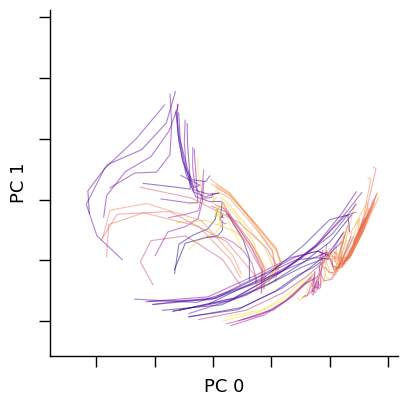

In [265]:
plot_dynamics(
    start='stim_onset_2',
    end='stim_offset_2',
    color_var='stim_2_loc',
    cmap='plasma',
    max_color_var=config['dim_ring'],
    start_mod=-1,
    end_mod=0,
)

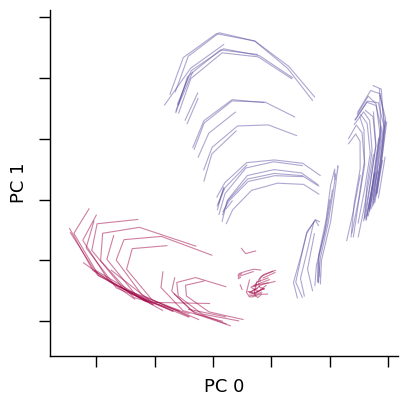

In [266]:
plot_dynamics(
    start='stim_offset_2',
    end=None,
    color_var='gt',
    cmap='Spectral',
    max_color_var=1,
    start_mod=-1,
    end_mod=0,
)

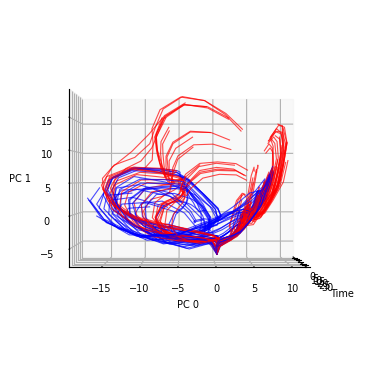

In [267]:
scale = 1.5
fig = plt.figure(figsize=(3 * scale, 3 * scale))
ax = fig.add_subplot(111, projection='3d')

for k in np.arange(0, 2, 2):  # Plot trajectories for k and k+1 components
    for i in range(info.shape[0]):
        color = 'red' if int(info.iloc[i]['ground_truth']) == 1 else 'blue'

        # Extract full trajectory over time for this sample and component pair
        pc_activities = pca.transform(activity[i])
        T = pc_activities.shape[1]
        t = np.arange(len(activity[i]))
        x = t
        y = pc_activities[:, k]
        z =  pc_activities[:, k+1]

        ax.plot(x, y, z, color=color, alpha=0.7, linewidth=0.8)

ax.set_ylabel(f'PC {k}')
ax.set_zlabel(f'PC {k+1}')
ax.set_xlabel('Time')
# ax.view_init(elev=30, azim=90) 
# plt.show()
ax.view_init(elev=0, azim=0) 
plt.show()

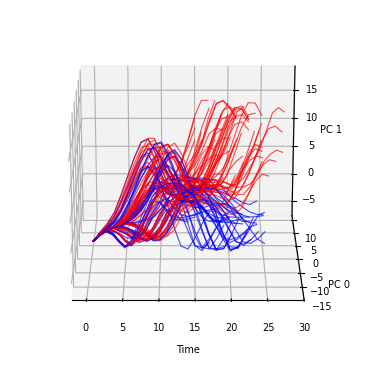

In [268]:
scale = 1.5
fig = plt.figure(figsize=(3 * scale, 3 * scale))
ax = fig.add_subplot(111, projection='3d')

for k in np.arange(0, 2, 2):  # Plot trajectories for k and k+1 components
    for i in range(info.shape[0]):
        color = 'red' if int(info.iloc[i]['ground_truth']) == 1 else 'blue'

        # Extract full trajectory over time for this sample and component pair
        pc_activities = pca.transform(activity[i])
        T = pc_activities.shape[1]
        t = np.arange(len(activity[i]))
        x = t
        y = pc_activities[:, k]
        z = pc_activities[:, k+1]

        ax.plot(x, y, z, color=color, alpha=0.7, linewidth=0.8)

ax.set_ylabel(f'PC {k}')
ax.set_zlabel(f'PC {k+1}')
ax.set_xlabel('Time')
# ax.view_init(elev=30, azim=90) 
# plt.show()
ax.view_init(elev=20, azim=-90) 
plt.show()

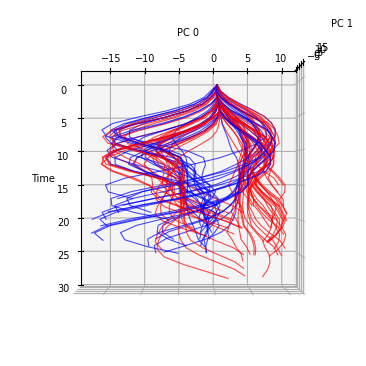

In [269]:
scale = 1.5
fig = plt.figure(figsize=(3 * scale, 3 * scale))
ax = fig.add_subplot(111, projection='3d')

for k in np.arange(0, 2, 2):  # Plot trajectories for k and k+1 components
    for i in range(info.shape[0]):
        color = 'red' if int(info.iloc[i]['ground_truth']) == 1 else 'blue'

        # Extract full trajectory over time for this sample and component pair
        pc_activities = pca.transform(activity[i])
        T = pc_activities.shape[1]
        t = np.arange(len(activity[i]))
        x = t
        y = pc_activities[:, k]
        z =  pc_activities[:, k+1]

        ax.plot(x, y, z, color=color, alpha=0.7, linewidth=0.8)

ax.set_ylabel(f'PC {k}')
ax.set_zlabel(f'PC {k+1}')
ax.set_xlabel('Time')
# ax.view_init(elev=30, azim=90) 
# plt.show()
ax.view_init(elev=90, azim=0) 
plt.show()

In [270]:
activity_reshape

fpf_hps = {
		'max_iters': 10000,
		'lr_init': 1e-3,
		'outlier_distance_scale': 10.0,
		'verbose': False, 
		'super_verbose': False,
        'tol_q': 5e-3,
        # 'tol_unique': 1e-3,
}

net.rnn.batch_first = False
net.single_unit_noise = 0
fpf = FixedPointFinder(net.rnn, **fpf_hps)

# Study the system in the absence of input pulses (e.g., all inputs are 0)
n_initial_states = 200
inputs = np.zeros([n_initial_states, config['dim_ring'] + 1])
samples = np.zeros(activity_reshape.shape[0]).astype(bool)
samples[:n_initial_states] = True
np.random.shuffle(samples)
initial_states = activity_reshape[samples, :]

# Run the fixed point finder
unique_fps, all_fps = fpf.find_fixed_points(initial_states, inputs)
print(len(unique_fps))

# for i in range(100):
#     it = initial_states[i, :]
#     print(np.dot(pca.components_[0, :], it), np.dot(pca.components_[1, :], it))

	Freezing model parameters so model is not affected by fixed point optimization.
		initial_states: 0 outliers detected (of 200).
		fixed points: 0 outliers detected (of 193).
	Decomposing Jacobians in a single batch.
	Sorting by Eigenvalue magnitude.
193


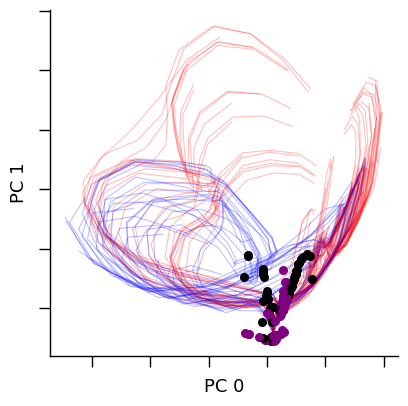

In [271]:
scale = 1.5
fig, ax = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale), sharex=False, sharey=True)

for k in np.arange(0, 2, 2):  # Plot trajectories for k and k+1 components
    for i in range(info.shape[0]):
        color = 'red' if int(info.iloc[i]['ground_truth']) == 1 else 'blue'

        # Extract full trajectory over time for this sample and component pair
        pc_activities = pca.transform(activity[i])
        T = pc_activities.shape[0]
        t = np.arange(len(activity[i]))

        ax.plot(pc_activities[:, k], pc_activities[:, k+1], color=color, alpha=0.25, linewidth=0.8, zorder=0)

        format_plot(ax)

    for i_f in range(unique_fps.xstar.shape[0]):
        fp = unique_fps[i_f]
        
        e_vals = fp.eigval_J_xstar[0]
        stable = np.all(np.abs(e_vals) <= 1.0)

        fp_pc = pca.transform(fp.xstar)

        ax.scatter(
            fp_pc[:, k],
            fp_pc[:, k+1],
            color = 'black' if stable else 'purple',
            s=30,
            zorder=1,
        )

ax.set_xticklabels([])
ax.set_yticklabels([])

ax.set_xlabel(f'PC {k}')
ax.set_ylabel(f'PC {k+1}')

plt.show()
None

In [272]:
activity_reshape

fpf_hps = {
		'max_iters': 10000,
		'lr_init': 1e-3,
		'outlier_distance_scale': 10.0,
		'verbose': False, 
		'super_verbose': False,
        'tol_q': 5e-3,
        # 'tol_unique': 1e-3,
}

net.rnn.batch_first = False
net.single_unit_noise = 0
fpf = FixedPointFinder(net.rnn, **fpf_hps)

# Study the system in the absence of input pulses (e.g., all inputs are 0)
n_initial_states = 200
inputs = np.zeros([n_initial_states, config['dim_ring'] + 1])
inputs[:, 0] = 1
samples = np.zeros(activity_reshape.shape[0]).astype(bool)
samples[:n_initial_states] = True
np.random.shuffle(samples)
initial_states = activity_reshape[samples, :]

# Run the fixed point finder
unique_fps, all_fps = fpf.find_fixed_points(initial_states, inputs)
print(len(unique_fps))

# for i in range(100):
#     it = initial_states[i, :]
#     print(np.dot(pca.components_[0, :], it), np.dot(pca.components_[1, :], it))

	Freezing model parameters so model is not affected by fixed point optimization.
		initial_states: 0 outliers detected (of 200).
		fixed points: 0 outliers detected (of 168).
	Decomposing Jacobians in a single batch.
	Sorting by Eigenvalue magnitude.
168


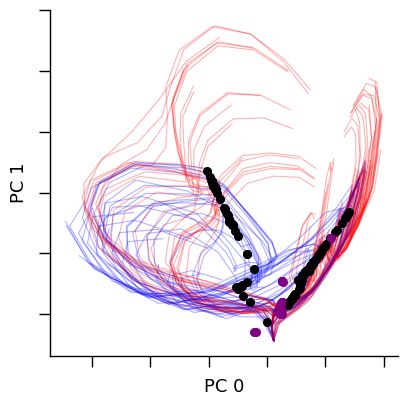

In [273]:
scale = 1.5
fig, ax = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale), sharex=False, sharey=True)

for k in np.arange(0, 2, 2):  # Plot trajectories for k and k+1 components
    for i in range(info.shape[0]):
        color = 'red' if int(info.iloc[i]['ground_truth']) == 1 else 'blue'

        # Extract full trajectory over time for this sample and component pair
        pc_activities = pca.transform(activity[i])
        T = pc_activities.shape[0]
        t = np.arange(len(activity[i]))

        ax.plot(pc_activities[:, k], pc_activities[:, k+1], color=color, alpha=0.3, linewidth=0.8, zorder=0)

        format_plot(ax)

    for i_f in range(unique_fps.xstar.shape[0]):
        fp = unique_fps[i_f]
        
        e_vals = fp.eigval_J_xstar[0]
        stable = np.all(np.abs(e_vals) <= 1.0)

        fp_pc = pca.transform(fp.xstar)

        ax.scatter(
            fp_pc[:, k],
            fp_pc[:, k+1],
            color = 'black' if stable else 'purple',
            s=30,
            zorder=1,
        )

ax.set_xticklabels([])
ax.set_yticklabels([])

ax.set_xlabel(f'PC {k}')
ax.set_ylabel(f'PC {k+1}')

plt.show()
None

In [275]:
activity_reshape

fpf_hps = {
		'max_iters': 10000,
		'lr_init': 1e-3,
		'outlier_distance_scale': 10.0,
		'verbose': False, 
		'super_verbose': False,
        'tol_q': 5e-3,
        # 'tol_unique': 1e-3,
}

net.rnn.batch_first = False
net.single_unit_noise = 0
fpf = FixedPointFinder(net.rnn, **fpf_hps)

# Study the system in the absence of input pulses (e.g., all inputs are 0)
n_initial_states = 200
inputs = np.zeros([n_initial_states, config['dim_ring'] + 1])
inputs[:, 0] = 1
inputs[:, 1:] = np.cos(2 * np.pi * (0 - np.arange(config['dim_ring'])) / config['dim_ring'])
samples = np.zeros(activity_reshape.shape[0]).astype(bool)
samples[:n_initial_states] = True
np.random.shuffle(samples)
initial_states = activity_reshape[samples, :]

# Run the fixed point finder
unique_fps, all_fps = fpf.find_fixed_points(initial_states, inputs)
print(len(unique_fps))

	Freezing model parameters so model is not affected by fixed point optimization.
		initial_states: 0 outliers detected (of 200).
		fixed points: 0 outliers detected (of 200).
	Decomposing Jacobians in a single batch.
	Sorting by Eigenvalue magnitude.
200


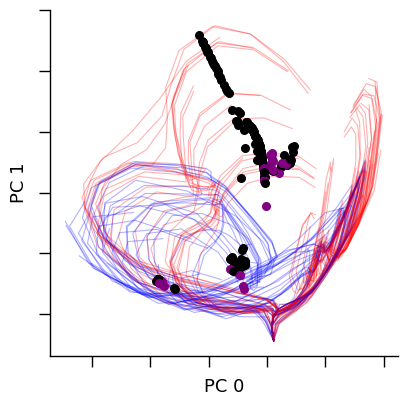

In [276]:
scale = 1.5
fig, ax = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale), sharex=False, sharey=True)

for k in np.arange(0, 2, 2):  # Plot trajectories for k and k+1 components
    for i in range(info.shape[0]):
        color = 'red' if int(info.iloc[i]['ground_truth']) == 1 else 'blue'

        # Extract full trajectory over time for this sample and component pair
        pc_activities = pca.transform(activity[i])
        T = pc_activities.shape[0]
        t = np.arange(len(activity[i]))

        ax.plot(pc_activities[:, k], pc_activities[:, k+1], color=color, alpha=0.3, linewidth=0.8, zorder=0)

        format_plot(ax)

    for i_f in range(unique_fps.xstar.shape[0]):
        fp = unique_fps[i_f]
        
        e_vals = fp.eigval_J_xstar[0]
        stable = np.all(np.abs(e_vals) <= 1.0)

        fp_pc = pca.transform(fp.xstar)

        ax.scatter(
            fp_pc[:, k],
            fp_pc[:, k+1],
            color = 'black' if stable else 'purple',
            s=30,
            zorder=1,
        )

ax.set_xticklabels([])
ax.set_yticklabels([])

ax.set_xlabel(f'PC {k}')
ax.set_ylabel(f'PC {k+1}')

plt.show()
None

In [65]:
activity_reshape

fpf_hps = {
		'max_iters': 10000,
		'lr_init': 1e-3,
		'outlier_distance_scale': 10.0,
		'verbose': False, 
		'super_verbose': False,
        'tol_q': 5e-3,
        # 'tol_unique': 1e-3,
}

net.rnn.batch_first = False
net.single_unit_noise = 0
fpf = FixedPointFinder(net.rnn, **fpf_hps)

# Study the system in the absence of input pulses (e.g., all inputs are 0)
n_initial_states = 200
inputs = np.zeros([n_initial_states, config['dim_ring'] + 1])
inputs[:, 0] = 1
inputs[:, 1:] = np.cos(2 * np.pi * (10 - np.arange(config['dim_ring'])) / config['dim_ring'])
samples = np.zeros(activity_reshape.shape[0]).astype(bool)
samples[:n_initial_states] = True
np.random.shuffle(samples)
initial_states = activity_reshape[samples, :]

# Run the fixed point finder
unique_fps, all_fps = fpf.find_fixed_points(initial_states, inputs)
print(len(unique_fps))

	Freezing model parameters so model is not affected by fixed point optimization.
		initial_states: 0 outliers detected (of 200).
		fixed points: 0 outliers detected (of 200).
	Decomposing Jacobians in a single batch.
	Sorting by Eigenvalue magnitude.
200


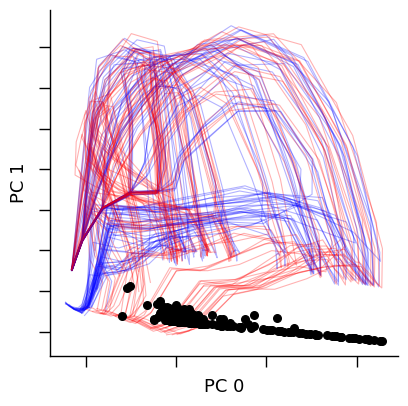

In [67]:
scale = 1.5
fig, ax = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale), sharex=False, sharey=True)

for k in np.arange(0, 2, 2):  # Plot trajectories for k and k+1 components
    for i in range(info.shape[0]):
        color = 'red' if int(info.iloc[i]['ground_truth']) == 1 else 'blue'

        # Extract full trajectory over time for this sample and component pair
        pc_activities = pca.transform(activity[i])
        T = pc_activities.shape[0]
        t = np.arange(len(activity[i]))

        ax.plot(pc_activities[:, k], pc_activities[:, k+1], color=color, alpha=0.3, linewidth=0.8, zorder=0)

        format_plot(ax)

    for i_f in range(unique_fps.xstar.shape[0]):
        fp = unique_fps[i_f]
        
        e_vals = fp.eigval_J_xstar[0]
        stable = np.all(np.abs(e_vals) <= 1.0)

        fp_pc = pca.transform(fp.xstar)

        ax.scatter(
            fp_pc[:, k],
            fp_pc[:, k+1],
            color = 'black' if stable else 'purple',
            s=30,
            zorder=1,
        )

ax.set_xticklabels([])
ax.set_yticklabels([])

ax.set_xlabel(f'PC {k}')
ax.set_ylabel(f'PC {k+1}')

plt.show()
None

In [72]:
activity_reshape

fpf_hps = {
		'max_iters': 10000,
		'lr_init': 1e-3,
		'outlier_distance_scale': 10.0,
		'verbose': False, 
		'super_verbose': False,
        'tol_q': 5e-3,
        # 'tol_unique': 1e-3,
}

net.rnn.batch_first = False
net.single_unit_noise = 0
fpf = FixedPointFinder(net.rnn, **fpf_hps)

# Study the system in the absence of input pulses (e.g., all inputs are 0)
n_initial_states = 200
inputs = np.zeros([n_initial_states, config['dim_ring'] + 1])
inputs[:, 0] = 1
inputs[:, 1:] = np.cos(2 * np.pi * (5 - np.arange(config['dim_ring'])) / config['dim_ring'])
samples = np.zeros(activity_reshape.shape[0]).astype(bool)
samples[:n_initial_states] = True
np.random.shuffle(samples)
initial_states = activity_reshape[samples, :]

# Run the fixed point finder
unique_fps, all_fps = fpf.find_fixed_points(initial_states, inputs)
print(len(unique_fps))

	Freezing model parameters so model is not affected by fixed point optimization.
		initial_states: 0 outliers detected (of 200).
		fixed points: 0 outliers detected (of 169).
	Decomposing Jacobians in a single batch.
	Sorting by Eigenvalue magnitude.
169


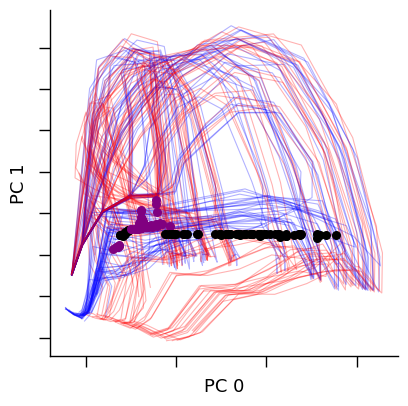

In [73]:
scale = 1.5
fig, ax = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale), sharex=False, sharey=True)

for k in np.arange(0, 2, 2):  # Plot trajectories for k and k+1 components
    for i in range(info.shape[0]):
        color = 'red' if int(info.iloc[i]['ground_truth']) == 1 else 'blue'

        # Extract full trajectory over time for this sample and component pair
        pc_activities = pca.transform(activity[i])
        T = pc_activities.shape[0]
        t = np.arange(len(activity[i]))

        ax.plot(pc_activities[:, k], pc_activities[:, k+1], color=color, alpha=0.3, linewidth=0.8, zorder=0)

        format_plot(ax)

    for i_f in range(unique_fps.xstar.shape[0]):
        fp = unique_fps[i_f]
        
        e_vals = fp.eigval_J_xstar[0]
        stable = np.all(np.abs(e_vals) <= 1.0)

        fp_pc = pca.transform(fp.xstar)

        ax.scatter(
            fp_pc[:, k],
            fp_pc[:, k+1],
            color = 'black' if stable else 'purple',
            s=30,
            zorder=1,
        )

ax.set_xticklabels([])
ax.set_yticklabels([])

ax.set_xlabel(f'PC {k}')
ax.set_ylabel(f'PC {k+1}')

plt.show()
None

In [74]:
activity_reshape

fpf_hps = {
		'max_iters': 10000,
		'lr_init': 1e-3,
		'outlier_distance_scale': 10.0,
		'verbose': False, 
		'super_verbose': False,
        'tol_q': 5e-3,
        # 'tol_unique': 1e-3,
}

net.rnn.batch_first = False
net.single_unit_noise = 0
fpf = FixedPointFinder(net.rnn, **fpf_hps)

# Study the system in the absence of input pulses (e.g., all inputs are 0)
n_initial_states = 200
inputs = np.zeros([n_initial_states, config['dim_ring'] + 1])
inputs[:, 0] = 1
inputs[:, 1:] = np.cos(2 * np.pi * (15 - np.arange(config['dim_ring'])) / config['dim_ring'])
samples = np.zeros(activity_reshape.shape[0]).astype(bool)
samples[:n_initial_states] = True
np.random.shuffle(samples)
initial_states = activity_reshape[samples, :]

# Run the fixed point finder
unique_fps, all_fps = fpf.find_fixed_points(initial_states, inputs)
print(len(unique_fps))

	Freezing model parameters so model is not affected by fixed point optimization.
		initial_states: 0 outliers detected (of 200).
		fixed points: 0 outliers detected (of 200).
	Decomposing Jacobians in a single batch.
	Sorting by Eigenvalue magnitude.
200


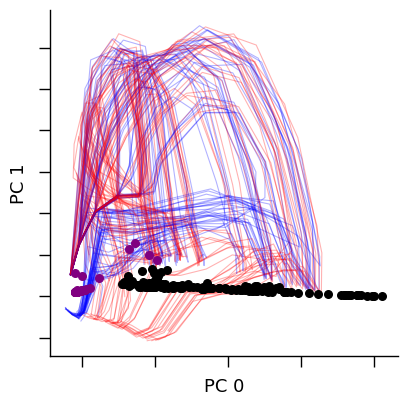

In [75]:
scale = 1.5
fig, ax = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale), sharex=False, sharey=True)

for k in np.arange(0, 2, 2):  # Plot trajectories for k and k+1 components
    for i in range(info.shape[0]):
        color = 'red' if int(info.iloc[i]['ground_truth']) == 1 else 'blue'

        # Extract full trajectory over time for this sample and component pair
        pc_activities = pca.transform(activity[i])
        T = pc_activities.shape[0]
        t = np.arange(len(activity[i]))

        ax.plot(pc_activities[:, k], pc_activities[:, k+1], color=color, alpha=0.3, linewidth=0.8, zorder=0)

        format_plot(ax)

    for i_f in range(unique_fps.xstar.shape[0]):
        fp = unique_fps[i_f]
        
        e_vals = fp.eigval_J_xstar[0]
        stable = np.all(np.abs(e_vals) <= 1.0)

        fp_pc = pca.transform(fp.xstar)

        ax.scatter(
            fp_pc[:, k],
            fp_pc[:, k+1],
            color = 'black' if stable else 'purple',
            s=30,
            zorder=1,
        )

ax.set_xticklabels([])
ax.set_yticklabels([])

ax.set_xlabel(f'PC {k}')
ax.set_ylabel(f'PC {k+1}')

plt.show()
None